In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Time Trends

We've explored American NEETs in the previous chapter, from how NEET rates vary by age, gender, race, state, having kids or having a disability. We've seen that generally:

- Overall, young women tend to have higher NEET rates than men, but this varies by age and demographic characteristics.
- NEET rates vary considerably by race, with Black men having the highest NEET rates at about one-in-five.
- NEET rates vary by state as well, with more than twenty states having higher male NEET rates.
- NEET rates are much higher for men and women how have a disabilty, and for young women have a child. 

In this chapter, we'll take a look at how NEET rates have changed over time, and if there really are more NEETs today than in the past, which anecdotally seems to be what many believe.

## Load the data

We'll be using the same function as we previously used, but we'll now extend the year interval. One of our key variables, `SCHLCOLL`, is only available after 1988 in the monthly surveys, so we'll just use the range of 1990 to 2024.

In [2]:
import sys
import os
from ipumspy import readers

sys.path.append('..')

from scripts.clean_ipums import get_CPS

Now we can extract our dataset. Note that this will take some time.

In [3]:
my_vars = ['AGE', 'SEX', 'RACE', 'HISPAN', 'NCHILD', 
           'DIFFANY', 'EMPSTAT', 'LABFORCE', 'SCHLCOLL', 'STATEFIP'] 

get_CPS(years=(1990, 2024), 
        vars=my_vars, 
        filename='timetrends_NEETs', 
        filepath='../datasets' 
        ) # extracting a fwf & xml, named '../datasets/timetrends_NEETs.[dat.gz/xml]'

Let's load it in. Let's only read in respondents within 16-24 years old, as they're the only ones we really need.

Let's get non-ASEC samples, and filter to ages within 16-24.

In [3]:
%%capture

ddi_cpstt = readers.read_ipums_ddi('../datasets/timetrends_NEETs.xml')
iter_cpstt = readers.read_microdata_chunked(ddi_cpstt, filename='../datasets/timetrends_NEETs.dat.gz', chunksize=50000)
timetrends = pd.concat([df[(df['AGE'] >= 16) & (df['AGE'] <= 24)] for df in iter_cpstt], ignore_index=True)

In [10]:
np.max(timetrends['AGE'])

np.int64(24)

Let's also filter out any observations with no recorded `EMPSTAT` or `SCHLCOLL`.

In [4]:
timetrends = timetrends.query('EMPSTAT > 0 and SCHLCOLL > 0')
timetrends.shape[0]

6869837

In [5]:
timetrends['EMPSTAT'].value_counts().sort_index()

EMPSTAT
10    3545949
12     121921
20      66750
21     328884
22      96318
30      13096
32      84843
34    2601052
35        963
36      10061
Name: count, dtype: Int64

Note that `EMPSTAT == 1` would mean that the respondent is in the armed forces. Individuals in the armed forces are asked a [limited set](https://cps.ipums.org/cps-action/variables/POPSTAT#description_section) of questions, so it makes sense that they're dropped from the dataset when we condition on an a present `SCHLCOLL` value. 

In [6]:
# by year
timetrends['YEAR'].value_counts().sort_index()

YEAR
1990    242709
1991    235769
1992    227623
1993    220371
1994    212492
1995    206303
1996    182587
1997    183709
1998    183463
1999    185311
2000    186896
2001    213311
2002    223200
2003    222193
2004    219639
2005    218863
2006    218076
2007    213723
2008    212307
2009    213337
2010    213493
2011    208144
2012    202942
2013    200185
2014    199696
2015    195591
2016    191006
2017    184847
2018    176122
2019    168005
2020    145635
2021    147413
2022    139853
2023    137499
2024    137524
Name: count, dtype: Int64

## NEETs over time

From the last chapter, in 2024 about 14% of both young men and women were NEETs. Let's look at how this changed over time. Let's take our `get_NEET()` function from before to speed up this process a bit.

In [18]:
def get_NEET(df = timetrends, query_str = '', group_by = [], asec = False):
    """
    calculates the NEET rate based on query and grouping options 

    **df**
    - dataframe, defaults to timetrends

    **query_str**
    - query string to be placed in pandas query method
    - ex. query_str = 'AGE == 25 and SEX == 1'

    **group_by**
    - grouping options to get NEET rates
    - ex. group_by = ['SEX', 'RACE']

    **asec**
    - bool == True if using ASEC rather than monthly CPS
    """
    filtered_df = df.query(query_str)

    if asec == True:
        agg_wt = filtered_df.groupby(group_by)['ASECWT'].sum().unstack() 
    else:
        agg_wt = filtered_df.groupby(group_by)['WTFINL'].sum().unstack() # get weighted sum by gender and NEET status

    agg_wt= agg_wt.eval('neet_rate = neet / (neet + not_neet) * 100')
    
    if len(group_by) > 2:
        agg_wt2 = agg_wt['neet_rate'].round(2).unstack()
        return agg_wt2
    else:
        return agg_wt['neet_rate']

Next, let's map our NEET, gender, race, state and disability variables.

In [6]:
import us

# NEET
timetrends['NEET'] = 'not_neet'
timetrends.loc[(timetrends['EMPSTAT'].isin(range(20,37))) & (timetrends['SCHLCOLL'] == 5), 'NEET'] = 'neet' # NEET conditions

#Gender
gender_codes = {1 : 'men', 2 : 'women'} # map gender codes
timetrends['sex'] = timetrends['SEX'].map(gender_codes)

# Race
race_codes = [
    ((timetrends['RACE'] == 100) & (timetrends['HISPAN'] == 0)),
    ((timetrends['RACE'] == 200) & (timetrends['HISPAN'] == 0)),
    ((timetrends['RACE'].isin(range(650, 653))) & (timetrends['HISPAN'] == 0)),
    ((timetrends['HISPAN'] > 0) & (timetrends['HISPAN'] < 902))
]
race_choices = ['white', 'black', 'asian', 'hispanic']
timetrends['race_cat'] = np.select(race_codes, race_choices, default = 'other')

# State
state_names = us.states.mapping('fips', 'name') # dictionary with STATEFIP as key
state_names['11'] = 'District of Columbia' # DC isn't included, so manually add it
timetrends['state'] = timetrends['STATEFIP'].astype(str).str.zfill(2) 
timetrends['state'] = timetrends['state'].map(state_names)

# Kids
child_dict = {i : 'has_child' for i in range(10) if i > 0}
child_dict[0] = 'no_child'
timetrends['kids'] = timetrends['NCHILD'].map(child_dict)


# Disability
disability_dict = {1 : 'no_dis', 2 : 'has_dis'}
timetrends['dis'] = timetrends['DIFFANY'].map(disability_dict)

Let's get one sample of our basic monthly data, and one sample of our ASEC data. We'll come back to the ASEC data at the end to compare results.

In [7]:
timetrends_asec = timetrends.query('ASECFLAG == 1 and ASECFLAG.notnull()').copy() # ASEC SAMPLES
timetrends = timetrends.query('ASECFLAG == 2 or ASECFLAG.isnull()')
print(timetrends['ASECFLAG'].min(), timetrends['ASECFLAG'].max())
print(timetrends_asec['ASECFLAG'].min(), timetrends_asec['ASECFLAG'].max())

2 2
1 1


### Overall Trends

Now, first question:

**'How have NEET rates changed over time for men and women?'**

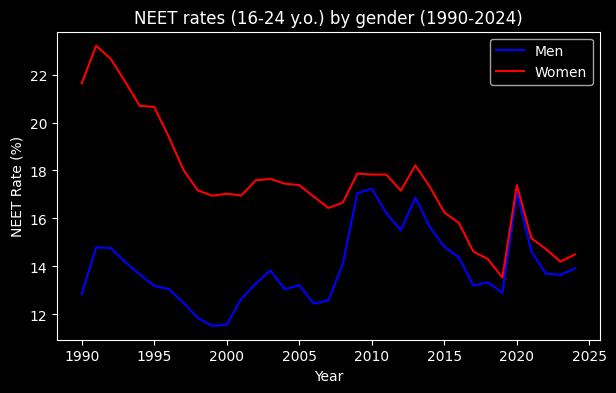

In [8]:
tt_overtime = get_NEET(timetrends, 'AGE >= 16', group_by=['YEAR', 'sex', 'NEET']) # redundant query, just put something there

plt.figure(figsize=(7,4))
plt.plot(tt_overtime.index, tt_overtime['men'], color = 'blue', label = 'Men')
plt.plot(tt_overtime.index, tt_overtime['women'], color = 'red', label = 'Women')
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) by gender (1990-2024)')
plt.legend();

NEET rates for women have droped by almost ten points from their peak over the past 34 years. After the GFC in the late 2010's, the gender gap in NEETs has noticeably slimmed. Let's look at the numbers by each decade, and include 2024.

In [9]:
for i in [1990, 2000, 2010, 2020, 2024]:
    print('Neets in {0}:\n{1}\n'.format(str(i),tt_overtime.loc[i,]))

Neets in 1990:
sex
men      12.85
women    21.63
Name: 1990, dtype: float64

Neets in 2000:
sex
men      11.58
women    17.03
Name: 2000, dtype: float64

Neets in 2010:
sex
men      17.24
women    17.83
Name: 2010, dtype: float64

Neets in 2020:
sex
men      17.09
women    17.39
Name: 2020, dtype: float64

Neets in 2024:
sex
men      13.92
women    14.50
Name: 2024, dtype: float64



We can see the spikes in 2010 and 2020, but the general downward trend for women, while the male NEET rate seems much more constant, aside from economic shocks. 

### By race

Next, let's look at by race. 

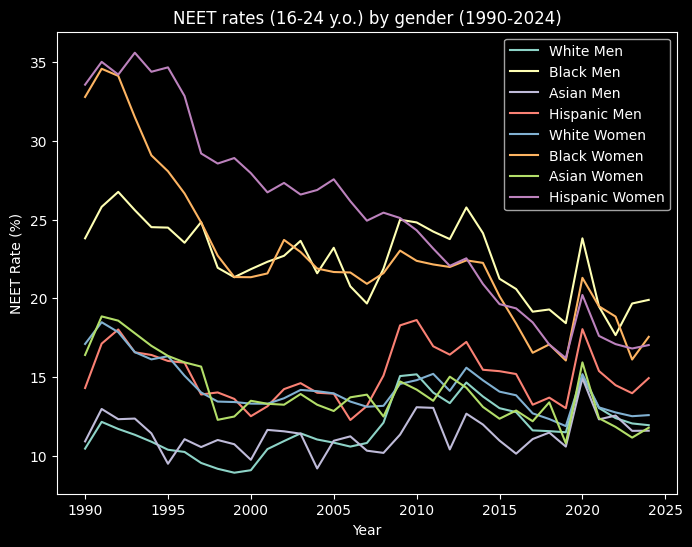

In [11]:
tt_byrace = get_NEET(timetrends, 'AGE >= 16', 
                     group_by=['YEAR', 'race_cat', 'sex', 'NEET']) # redundant query, just put something there


unstacked_race = tt_byrace.unstack()

plt.figure(figsize=(8,6))
for i in ['men', 'women']:
    for k in race_choices: # excluding other
        plot_label = '{0} {1}'.format(k, i).title()
        plt.plot(unstacked_race.index, unstacked_race[(i, k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) by gender (1990-2024)')
plt.legend();

Let's also look at each gender seperately. First, for men by race.

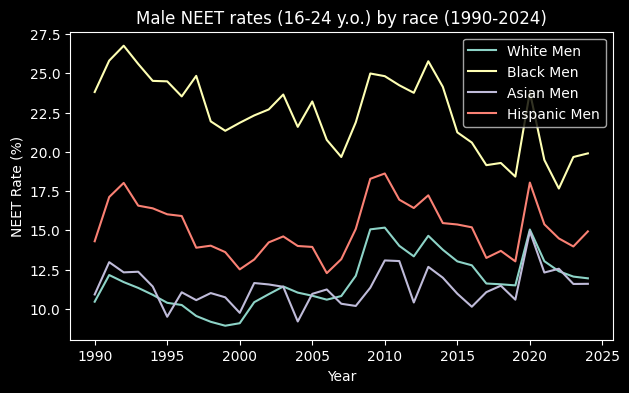

In [12]:
plt.figure(figsize=(7,4))
for k in race_choices: # excluding other
    plot_label = '{0} men'.format(k, i).title()
    plt.plot(unstacked_race.index, unstacked_race[('men', k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('Male NEET rates (16-24 y.o.) by race (1990-2024)')
plt.legend();

NEET rates for White, Hispanic and Asian young men stayed around the same estimates, while the rate for Black Men has slightly declined. How about for women?

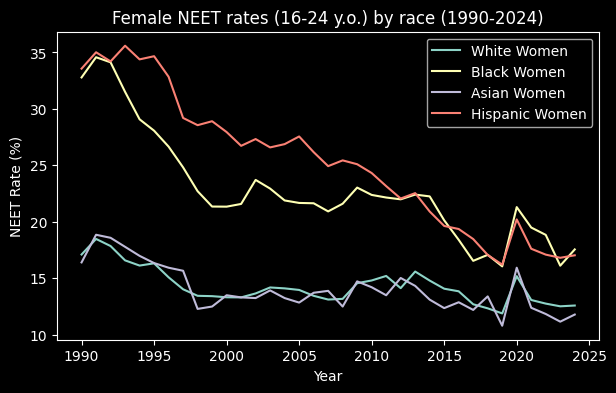

In [13]:
plt.figure(figsize=(7,4))
for k in race_choices: # excluding other
    plot_label = '{0} women'.format(k, i).title()
    plt.plot(unstacked_race.index, unstacked_race[('women', k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('Female NEET rates (16-24 y.o.) by race (1990-2024)')
plt.legend();

NEET rates have declined for women of all races, but most drastically for Black and Hispanic women. 

Let's just compare 1990 to 2024.

In [16]:
print('NEET rates (16-24 y.o.) by race/gender (1990):\n{0}\n'.format(unstacked_race.loc[1990].unstack()))
print('NEET rates (16-24 y.o.) by race/gender (2024):\n{0}'.format(unstacked_race.loc[2024].unstack()))

NEET rates (16-24 y.o.) by race/gender (1990):
race_cat  asian  black  hispanic  other  white
sex                                           
men       10.91  23.81     14.30  17.88  10.45
women     16.40  32.79     33.57  29.76  17.10

NEET rates (16-24 y.o.) by race/gender (2024):
race_cat  asian  black  hispanic  other  white
sex                                           
men       11.59  19.90     14.93  16.66  11.94
women     11.78  17.55     17.03  16.02  12.58


Black and Hispanic women had their NEET rates reduced by 50%. Rates for men, besides Black men, have largely stayed the same. 

### Other variables (disability and caretaking)

Next, let's look at NEET rates over time by disability status.

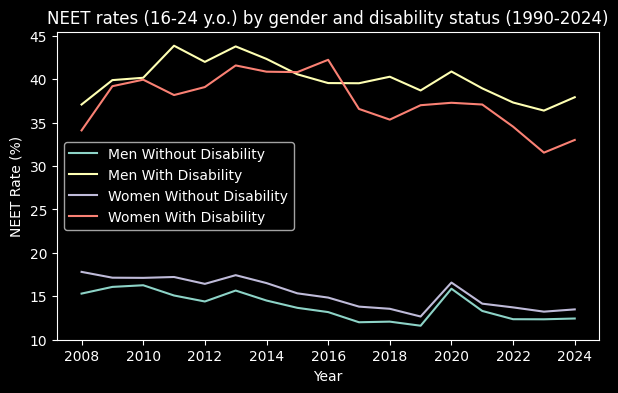

In [14]:
tt_bydis = get_NEET(timetrends, 'AGE >= 16', 
                     group_by=['YEAR', 'dis', 'sex', 'NEET']) # redundant query, just put something there


unstacked_dis = tt_bydis.unstack()

plt.figure(figsize=(7,4))
for i in ['men', 'women']:
    for k in ['no_dis', 'has_dis']: # excluding other
        k2 = 'with disability' if k == 'has_dis' else 'without disability'
        plot_label = '{1} {0}'.format(k2, i).title()
        plt.plot(unstacked_dis.index, unstacked_dis[(i, k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) by gender and disability status (1990-2024)')
plt.legend();

I forgot that the `DIFFANY` variable is [only available](https://cps.ipums.org/cps-action/variables/DIFFANY#availability_section) from 2008 onwards, so we have a shorter timeline. NEET rates by gender and disability status haven't changed much, though it actually looks like rates for those without a disability have actually declined slightly; this is affected by there being a recession around that time though, so maybe a year like 2016-2018 are better to compare to 2024. Let's look at those

In [18]:
print('NEET rates (16-24 y.o.) by disability/gender (2008):\n{0}'.format(unstacked_dis.loc[2008].unstack()))
print('NEET rates (16-24 y.o.) by disability/gender (2016):\n{0}'.format(unstacked_dis.loc[2016].unstack()))
print('NEET rates (16-24 y.o.) by disability/gender (2024):\n{0}'.format(unstacked_dis.loc[2024].unstack()))

NEET rates (16-24 y.o.) by disability/gender (2008):
dis    has_dis  no_dis
sex                   
men      37.08   15.31
women    34.10   17.81
NEET rates (16-24 y.o.) by disability/gender (2016):
dis    has_dis  no_dis
sex                   
men      39.55   13.18
women    42.23   14.85
NEET rates (16-24 y.o.) by disability/gender (2024):
dis    has_dis  no_dis
sex                   
men      37.92   12.44
women    33.00   13.49


There's still been a slight decline, even from 2016. Could the stagnation overall, then, be that more young men and women have cognitive or physicaly disabilities? We only have data back to 2008, but let's look at that briefly.

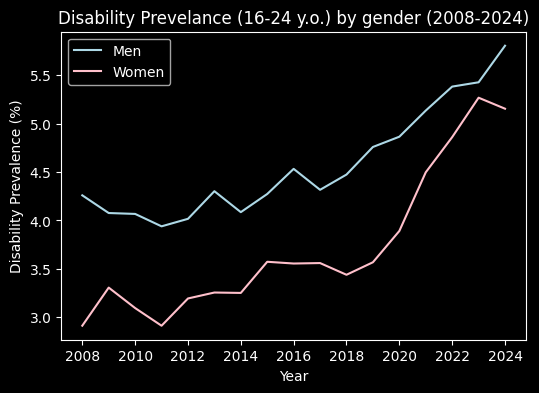

In [15]:
dis_q = timetrends.groupby(['YEAR', 'sex', 'dis'])['WTFINL'].sum().unstack()
dis_q = dis_q.eval('dis_rate = has_dis / (has_dis + no_dis) * 100')['dis_rate'].unstack()

plt.figure(figsize=(6,4))
plt.plot(dis_q.index, dis_q['men'], color = 'lightblue', label='Men')
plt.plot(dis_q.index, dis_q['women'], color = 'pink', label='Women')
plt.xlabel('Year')
plt.ylabel('Disability Prevalence (%)')
plt.title('Disability Prevelance (16-24 y.o.) by gender (2008-2024)')
plt.legend();

It's a jump by about 1.5 percentage-points for both men and women, which isn't huge, but still meaningful. This compositional shift could explain the overall trends, though I haven't thought about it too much. Interesting nonetheless. 

Let's keep moving. Onto looking at NEETs over time by having kids. Fortunately, `NCHILD` has been available over our entire time period, so we can get the whole picture.

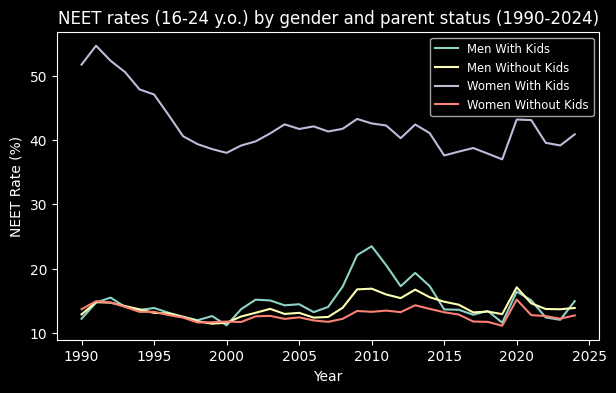

In [16]:
tt_bykids = get_NEET(timetrends, 'AGE >= 16', 
                     group_by=['YEAR', 'kids', 'sex', 'NEET']) # redundant query, just put something there


unstacked_kids = tt_bykids.unstack()

plt.figure(figsize=(7,4))
for i in ['men', 'women']:
    for k in ['has_child', 'no_child']: # excluding other
        k2 = 'with kids' if k == 'has_child' else 'without kids'
        plot_label = '{1} {0}'.format(k2, i).title()
        plt.plot(unstacked_kids.index, unstacked_kids[(i, k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) by gender and parent status (1990-2024)')
plt.legend(loc = 'upper right', fontsize = 'small');

NEET rates for women with kids have dropped by about ten percentage points over the past twenty-four years, though most of this decline came before the 2000s. NEET rates for men with kids have stayed relatively constant aside from economic shocks, and rates for men and women without kids have also stayed about the same. 

Let's briefly look at the intersection of men and women without a disability and any kids.

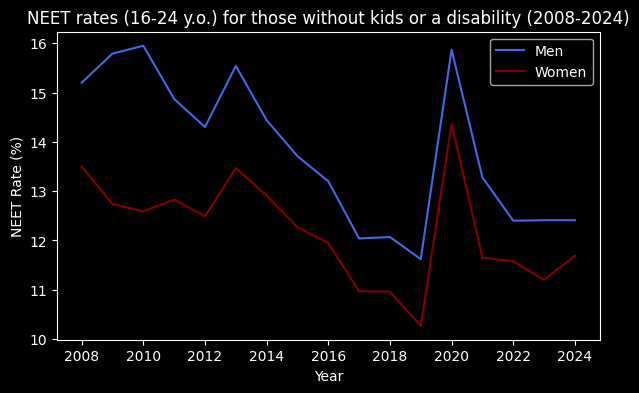

In [21]:
tt_nokidsnodis = get_NEET(timetrends, 'AGE >= 16 and dis == "no_dis" and kids == "no_child"', 
                     group_by=['YEAR', 'sex', 'NEET']) 


plt.figure(figsize=(7,4))
plt.plot(tt_nokidsnodis.index, tt_nokidsnodis['men'], color = 'royalblue', label = 'Men')
plt.plot(tt_nokidsnodis.index, tt_nokidsnodis['women'], color = 'maroon', label = 'Women')
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) for those without kids or a disability (2008-2024)')
plt.legend();

For men and women without kids or a disability, NEET rates have dropped by about a couple percentage points, again relative to 2008, so they've stayed relatively stable when ignoring economic shocks. Of those with no kids or disability, men have consistently had higher NEET rates, at least for 16 years. 

Just out of curiousity, what share of the 16-24 year-old population has no kids or disability?

In [22]:
est_nknd = timetrends.query('YEAR == 2024 and dis == "no_dis" and kids == "no_child"')['WTFINL'].sum()
est_tot = timetrends.query('YEAR == 2024')['WTFINL'].sum()
perc_nknd = est_nknd / est_tot * 100
str(round(perc_nknd, 3)) + '% no kids no disability in 2024'

'90.41% no kids no disability in 2024'

About nine-in-ten 16-24 year-olds had no kids or disability in 2024. Let's look at the reverse. Conditional on being a NEET, what is the likelihood of being disabled or having a kid?



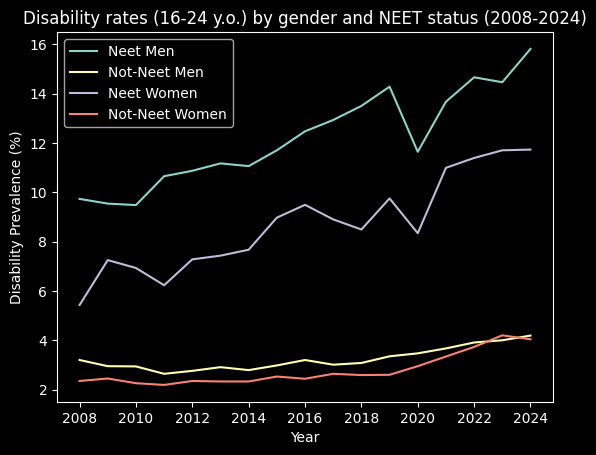

In [8]:
neet_only_dis = timetrends.groupby(['YEAR', 'NEET', 'sex', 'dis'])['WTFINL'].sum().unstack() 
neet_only_dis= neet_only_dis.eval('dis_rate = has_dis / (has_dis + no_dis) * 100')
neet_only_dis_rates = neet_only_dis['dis_rate'].round(2).unstack().unstack()

for i in ['men', 'women']:
    for k in ['neet', 'not_neet']:
        k2 = 'NEET' if k == 'neet' else 'not-NEET'
        plot_label = '{0} {1}'.format(k2, i).title()
        plt.plot(neet_only_dis_rates.index, neet_only_dis_rates[(i, k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('Disability Prevalence (%)')
plt.title('Disability rates (16-24 y.o.) by gender and NEET status (2008-2024)')
plt.legend();

Let's also just get the 2024 numbers.

In [34]:
neet_only_dis_rates.loc[2024]

sex    NEET    
men    neet        15.81
       not_neet     4.19
women  neet        11.73
       not_neet     4.04
Name: 2024, dtype: float64

Let's now look at prevalence of having a child, conditional on being a NEET.

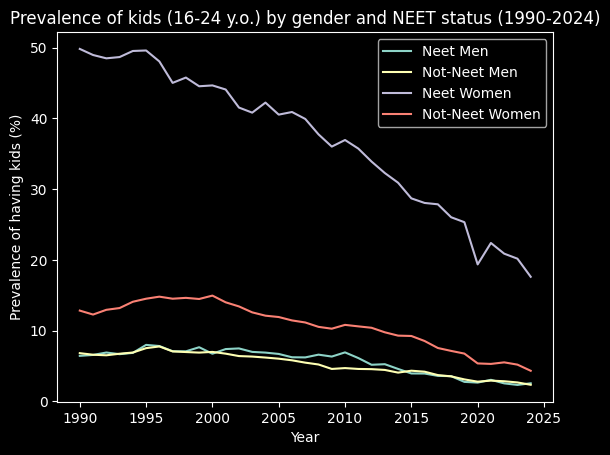

In [9]:
neet_only_kids = timetrends.groupby(['YEAR', 'NEET', 'sex', 'kids'])['WTFINL'].sum().unstack() 
neet_only_kids = neet_only_kids.eval('kids_rate = has_child / (has_child + no_child) * 100')
neet_only_kids_rates = neet_only_kids['kids_rate'].round(2).unstack().unstack()

for i in ['men', 'women']:
    for k in ['neet', 'not_neet']:
        k2 = 'NEET' if k == 'neet' else 'not-NEET'
        plot_label = '{0} {1}'.format(k2, i).title()
        plt.plot(neet_only_kids_rates.index, neet_only_kids_rates[(i, k)], label = plot_label)
plt.xlabel('Year')
plt.ylabel('Prevalence of having kids (%)')
plt.title('Prevalence of kids (16-24 y.o.) by gender and NEET status (1990-2024)')
plt.legend();

And the 2024 numbers.

In [10]:
neet_only_kids_rates.loc[2024]

sex    NEET    
men    neet         2.55
       not_neet     2.34
women  neet        17.61
       not_neet     4.32
Name: 2024, dtype: float64

### State-level trends

Finally, let's look at NEET rates by state over time.

NEET Rates for 16-24 y.o. by gender and state (1990 - 2024):



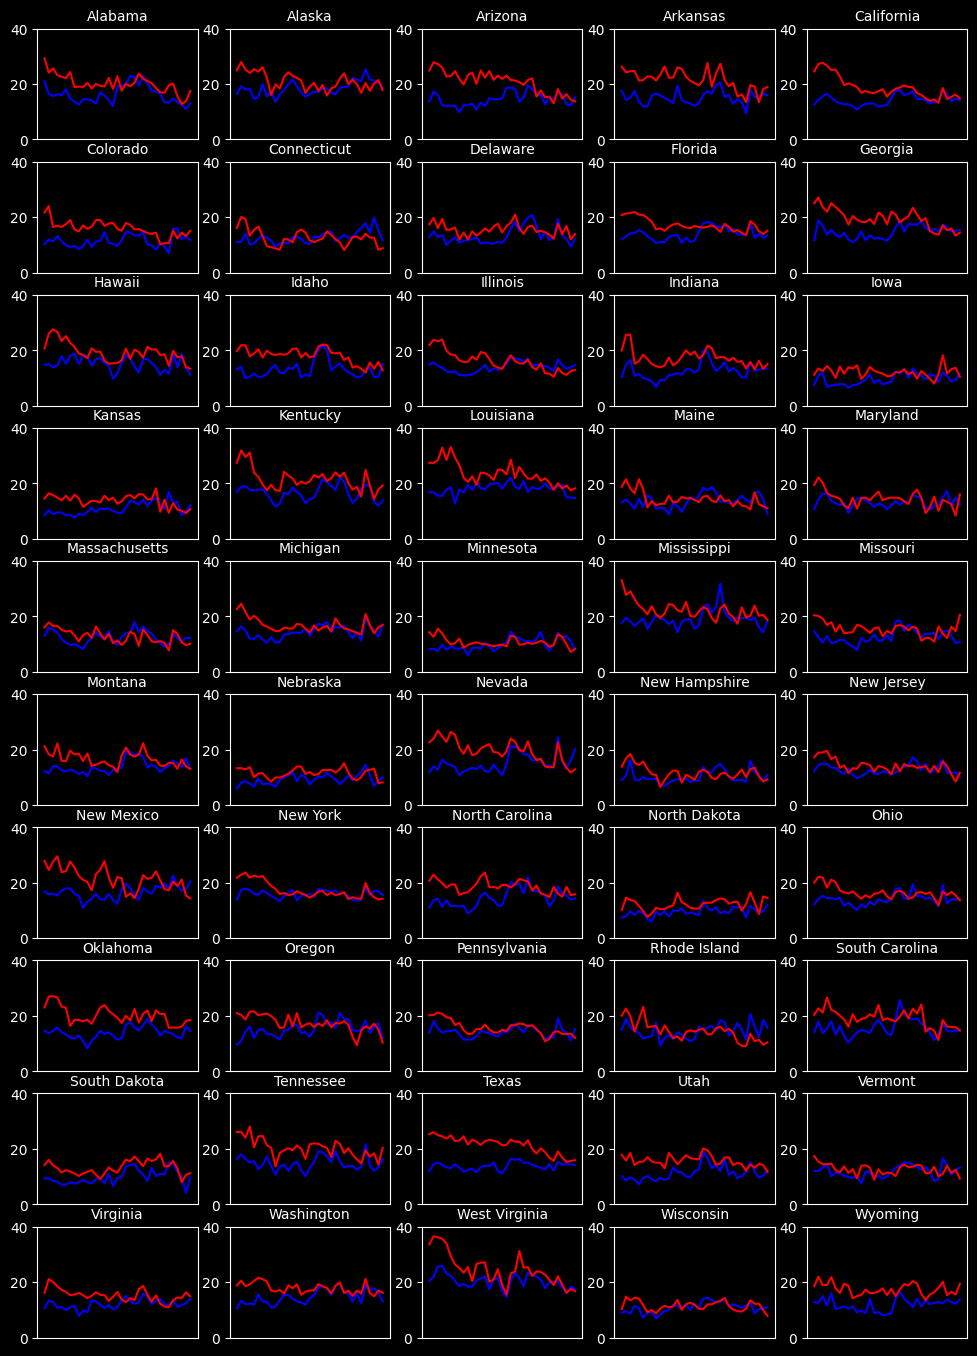

In [17]:
tt_bystate = get_NEET(timetrends, 'AGE >= 16', 
                     group_by=['YEAR', 'state', 'sex', 'NEET']) # redundant query, just put something there


unstacked_state = tt_bystate.unstack()

fig, axes = plt.subplots(10,5, figsize=(12,17))
axes = axes.ravel()

stnames = list(state_names.values())

print('NEET Rates for 16-24 y.o. by gender and state (1990 - 2024):\n')
for i in range(50):
    axes[i].plot(unstacked_state.index, unstacked_state[('men', stnames[i])], color = 'blue')
    axes[i].plot(unstacked_state.index, unstacked_state[('women', stnames[i])], color = 'red')
    axes[i].set_ylim(0,40)
    axes[i].set_xticks([])
    axes[i].set_title(stnames[i], fontsize = 'medium')

## ASEC

As I mentioned earlier, we'll take a quick look at NEET estimates when using the CPS ASEC. As a reminder, the Annual Social and Economic Supplement (ASEC) is conducted annually, including [all March respondents](https://catalog.data.gov/dataset/current-population-surveyannual-social-and-economicsupplement-980f9) and oversamples from other months. The ASEC is used for a host of [national-level metrics](https://catalog.data.gov/dataset/current-population-surveyannual-social-and-economicsupplement-980f9), and includes more detailed survey questions than what is included in monthly CPS sets. 

For now, we'll just be repeating our previous analysis with ASEC data, but in the future, we may come back to the ASEC to study the profile of NEETs more specifically.

Let's take a quick look at our ASEC data first.

In [19]:
timetrends_asec.shape

(731881, 29)

In [24]:
timetrends_asec['MONTH'].max() # just to make sure

np.int64(3)

In [25]:
timetrends_asec['YEAR'].value_counts().sort_index()

YEAR
1990    19887
1991    19502
1992    18932
1993    18498
1994    17663
1995    17542
1996    15299
1997    15526
1998    15287
1999    15473
2000    15887
2001    26276
2002    26142
2003    26195
2004    26045
2005    25454
2006    25825
2007    25084
2008    25228
2009    25421
2010    25559
2011    24710
2012    23821
2013    24160
2014    23429
2015    23225
2016    21488
2017    21240
2018    20337
2019    20080
2020    16942
2021    17659
2022    16475
2023    15768
2024    15822
Name: count, dtype: Int64

In [27]:
timetrends_asec['AGE'].describe()

count     731881.0
mean     19.685396
std       2.627315
min           16.0
25%           17.0
50%           19.0
75%           22.0
max           24.0
Name: AGE, dtype: Float64

Okay, the main points seem to check out. Let's look at overall NEET rates by gender with the ASEC, and plot them in comparison to our previous estimates.

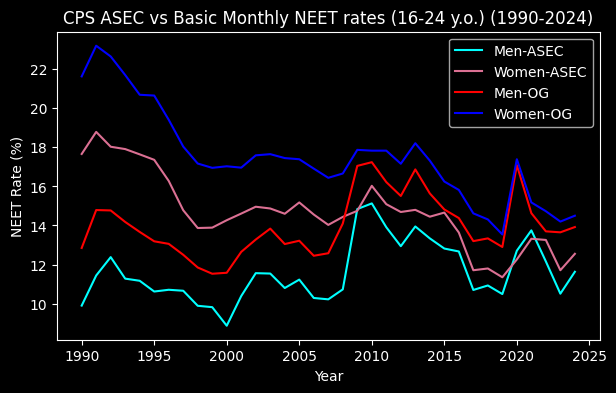

In [35]:
tt_asec_overtime = get_NEET(timetrends_asec, 'AGE >= 16', group_by=['YEAR', 'sex', 'NEET'], asec=True)

plt.figure(figsize=(7,4))

plt.plot(tt_asec_overtime.index, tt_asec_overtime['men'], color = 'cyan', label = 'Men-ASEC')
plt.plot(tt_asec_overtime.index, tt_asec_overtime['women'], color = 'palevioletred', label = 'Women-ASEC')

plt.plot(tt_overtime.index, tt_overtime['men'], color = 'red', label = 'Men-OG')
plt.plot(tt_overtime.index, tt_overtime['women'], color = 'blue', label = 'Women-OG')

plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('CPS ASEC vs Basic Monthly NEET rates (16-24 y.o.) (1990-2024)')
plt.legend();

In [31]:
print(tt_asec_overtime.loc[1990])
print(tt_asec_overtime.loc[2024])

sex
men       9.90
women    17.66
Name: 1990, dtype: float64
sex
men      11.63
women    12.55
Name: 2024, dtype: float64


We find slightly lower NEET rates with the ASEC. Remember that we found 13.9% and 14.5% for men and women, respectively, using the basic monthly sets. The general patterns, though, are about the same: a shrinking in the NEET gap, with female and male patterns mirroring strongly now. 

This makes sense when you consider how our key variables are coded. From the description of `SCHLCOLL`:
- 'College or high school students who were currently on holiday or seasonal vacation were to answer yes [to being in school], but those not taking classes during summer vacation were to answer no.'

And if there are seasonal [peaks]troughs in [un]employment NOT occuring in March, these two facts could easily contribute to the ASEC having lower NEET rates. 

Let's first look at if NEET rates are higher in the summer months than the rest of year (while acknowledging that this needn't be entirely to `SCHLCOLL`).

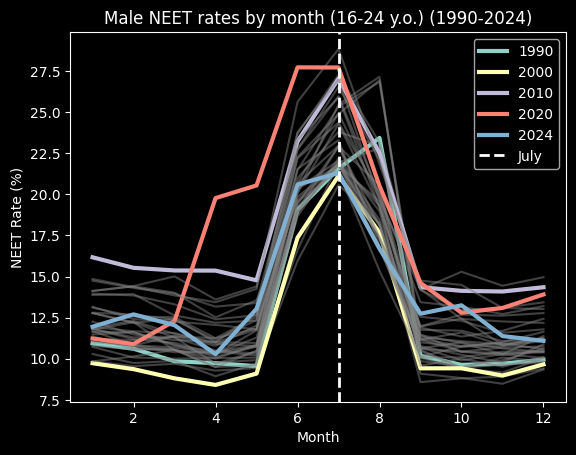

In [54]:
tt_bymonth = get_NEET(timetrends, 'AGE >= 16', group_by=['MONTH', 'YEAR', 'sex', 'NEET'])
tt_bymonth = tt_bymonth.unstack()

for i in range(1990, 2025):
    if i in range(1990, 2021, 10) or i == 2024:
        plt.plot(tt_bymonth.index, tt_bymonth[('men', i)], label = str(i), linewidth=3)
    else:
        plt.plot(tt_bymonth.index, tt_bymonth[('men', i)], color = 'gray', alpha = .5)
plt.axvline(7, label = 'July', color = 'white', linestyle='--', linewidth=2)
plt.xlabel('Month')
plt.ylabel('NEET Rate (%)')
plt.title('Male NEET rates by month (16-24 y.o.) (1990-2024)');
plt.legend();

Well that explains it. Theres a peak of NEETs in in the summer months, likely from how those respondents are being coded by `SCHLCOLL`. What would our original estimates look like if we exclude respondents from June, July and August?

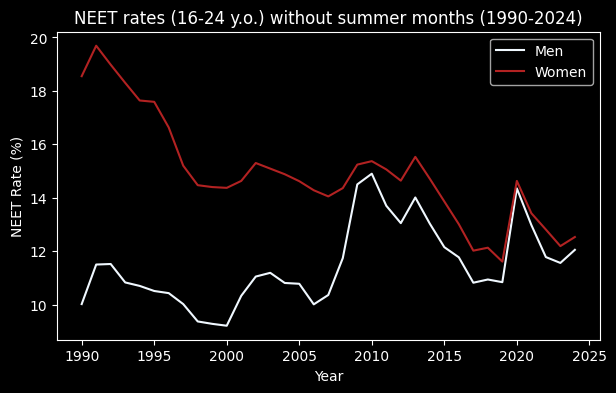

In [58]:
tt_noSUMMER = get_NEET(timetrends, 'MONTH < 6 or MONTH > 8', group_by=['YEAR', 'sex', 'NEET']) 

plt.figure(figsize=(7,4))
plt.plot(tt_noSUMMER.index, tt_noSUMMER['men'], color = 'aliceblue', label = 'Men')
plt.plot(tt_noSUMMER.index, tt_noSUMMER['women'], color = 'firebrick', label = 'Women')
plt.xlabel('Year')
plt.ylabel('NEET Rate (%)')
plt.title('NEET rates (16-24 y.o.) without summer months (1990-2024)')
plt.legend();

In [61]:
print('NEET rates WITHOUT summer months:\n{0}\n'.format(tt_noSUMMER.loc[2024]))
print('NEET rates WITH summer months:\n{0}\n'.format(tt_overtime.loc[2024]))

NEET rates WITHOUT summer months:
sex
men      12.05
women    12.53
Name: 2024, dtype: float64

NEET rates WITH summer months:
sex
men      13.92
women    14.50
Name: 2024, dtype: float64



That's almost a about a two-point increase for 2024 NEETs when including the summer months. I think it'd be fair to say that rates without the summer months (either Basic Monthly or ASEC) better reflects the true NEET rate.

But as a final look, let's see how employment rates vary over the course of the year for 16-24 year-olds.

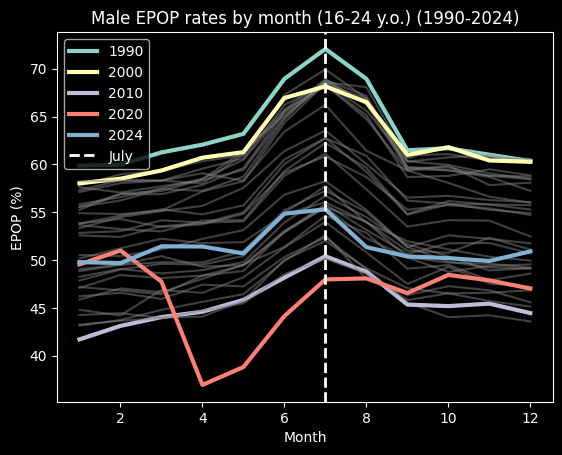

In [ ]:
timetrends['emp'] = 'not_emp'
timetrends.loc[(timetrends['EMPSTAT'].isin(range(1,13))), 'emp'] = 'yes_emp' 

emprate = timetrends.groupby(['MONTH', 'YEAR', 'sex', 'emp'])['WTFINL'].sum().unstack() 

emprate = emprate.eval('emp_rate = yes_emp / (yes_emp + not_emp) * 100').unstack()
epop = emprate['emp_rate'].round(2).unstack()

for i in range(1990, 2025):
    if i in range(1990, 2021, 10) or i == 2024:
        plt.plot(epop.index, epop[('men', i)], label = str(i), linewidth=3)
    else:
        plt.plot(epop.index, epop[('men', i)], color = 'gray', alpha = .5)
plt.axvline(7, label = 'July', color = 'white', linestyle='--', linewidth=2)
plt.xlabel('Month')
plt.ylabel('EPOP (%)')
plt.title('Male EPOP rates by month (16-24 y.o.) (1990-2024)');
plt.legend();

So `EMPSTAT` doesn't seem to be the issue. Employment rates for 16-24 year-olds are higher in the summer months, which makes sense of course. We have two counteracting forces then in the summer months: young people are more likely to be 'considered' as not in school, and young people are also more likely to be employed. 

I think this gives us justification to to ignore the summer months (June, July, August) as they seem to create some artificial distortions in our data, primarily through `SCHLCOLL`.